Pred tým ako začneme  je potrebne stiahnuť potrebné knižnice a následne ich naimportovať aby sme ich mohli použiť.

In [ ]:
pip install nltk
nltk.download('wordnet')
nltk.download('stopwords')
pip install keras
pip install tensorflow
pip install random

In [1]:
import pandas  as pd
import numpy as np
import os
import random
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, Flatten, Input,MaxPooling1D,Dense, Dropout ,Conv1D
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Následne načítame požadovanú dátovú množinu a zobrazíme si prvé riadky dát.

In [2]:
df_data=pd.read_csv(r'data.csv') 

Dátový súbor je tvorený z piatich atribútov. Pre našu úlohu sú potrebné len atribúty text a label. Atribút label je cieľový atribút.

In [3]:
df_data.head()

,id,title,author,text,label
0,12159,Trump Has Gotten The Republican Party Sued For...,Jason Easley,The Washington Post reported : \nThe Democrati...,1
1,11921,Hand-Foot-And-Mouth Disease On The Rise: What ...,Dikran Arakelian (noreply@blogger.com),Share on Facebook Every parents worries about ...,1
2,17066,Show biz: Business and breakthroughs,Vanessa Frank,Show biz: Business and breakthroughs Exclusive...,1
3,728,How Voting Machines Are Programmed In Order To...,pcr3,How Voting Machines Are Programmed In Order To...,1
4,6058,Iranians arrested after celebrating ancient Pe...,Kaitlyn Stegall,"November 1, 2016 Iranians arrested after celeb...",1


Ak máme dátovú množinu načítanú môžeme prejsť do fázy predspracovania. V tejto časti vyberieme požadované atribúty s ktorými budeme pracovať teda text a label. Následne odstránime prázdne riadky a viac úkonom predspracovania nebudeme robiť. Nebudeme odstraňovať žiadne zastavovacie slova ani iné znaky v texte.  Pri detekcií falošných správ je dôležité ponechať text v pôvodom tvare, lebo pri nejakej úprave by mohli byť odstránené črty textu, ktoré popisujú falošné správy.

In [4]:
df_data=df_data[['text', 'label']] #výber len dvoch potrebných atribútov

Teraz si overime, či sa v dátovej množine nachádzajú riadky s hodnotou NULL. Ak áno zistime, v ktorom atribúte sa nachádzajú.

In [5]:
df_data.isnull().values.any()    # kontrola null hodnot

True

In [6]:
df_data.isnull().sum() #atrút text má jeden prázdy riadok

text     1
label    0
dtype: int64

V tomto procese odstránime všetky riadky s hodnotou NULL. Avšak v súbore môžu byť riadky aj ktoré sú prázdne ale nemajú hodnotu NULL takže odstránime aj tie. Na koniec skontrolujeme, či v datasete sú ešte nejaké prázdne riadky.

In [7]:
df_data=df_data[df_data['text'].notnull()]
df_data["text"]=df_data["text"].str.strip()
df_data.text.replace('', np.NaN, inplace=True)###nahradenie prazdneho riadka hodnotou NAN
np.sum(df_data.isnull().any(axis=1))
df_data[df_data.isnull().any(axis=1)].head()
df_data.dropna(inplace=True)  ###odstranneie riadkov NaN
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7598 non-null   object
 1   label   7598 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 178.1+ KB


In [8]:
df_data.isnull().values.any() ####overíme, či v datasete sú ešte prázdne riadky


False

V datasete sa už nenachádzajú žiadne práznde riadky, takže môžeme pokračovať ďalej. 
Zobrazíme si výslednú množinu s ktorou budeme pracovať. Výsledná množina má dve atribúty a je tvorená z 7598 údajov.

In [9]:
print(df_data.head()) 

                                                text  label
0  The Washington Post reported : \nThe Democrati...      1
1  Share on Facebook Every parents worries about ...      1
2  Show biz: Business and breakthroughs Exclusive...      1
3  How Voting Machines Are Programmed In Order To...      1
4  November 1, 2016 Iranians arrested after celeb...      1


Aby sme zistili ako sú hodnotené texty v dátasete vyjtvoríme si graf. Tento graf vyjadruje početnosť tried v atribúte label.
Hodnota 1 vyjadruje že text je falošný a hodnota 0 vyjadruje, že text je reálny. Ako môžete vidieť na grafe prevládajú reálne nad falošnými správami. Falošných je len niečo okolo 8%.

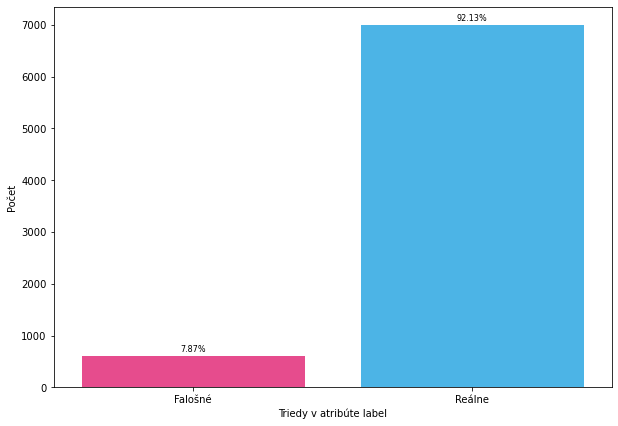

In [10]:
plt.figure(figsize=(10,7))
plot = sns.countplot(x='label', data=pd.DataFrame(df_data['label'].map({False:'Reálne',True:'Falošné'}), columns=['label']),palette=["#FF3389", "#33BDFF"])

ax = plot.axes
ax.set(xlabel="Triedy v atribúte label", ylabel = "Počet")


for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / df_data.shape[0]:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center',
                fontsize=8, 
                color='black',
                xytext=(0,7), 
                textcoords='offset points')




Ďalší graf, ktorý si zobrazíme vyjaruje kpľko znakov majú jednotlivé texty. Ako môžeme vidieť na grafe najviac textov má okolo 5000 znakov. 

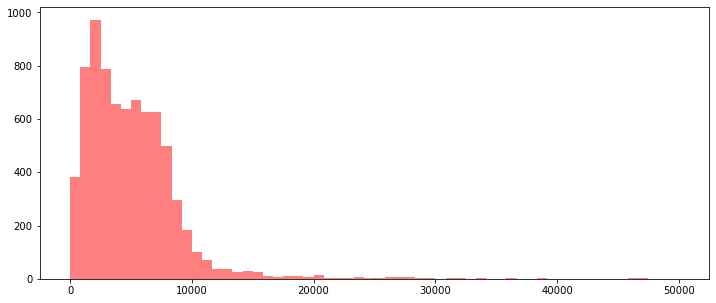

In [11]:
data_length = df_data.text.apply(len)
data_length.head()
plt.figure(figsize = (12, 5))
plt.hist(data_length, bins = 60, range = [0, 50000], alpha = 0.5, color = 'r')
plt.show()

Pred samotným modelovaním je potrebné si rozdeliť dátovú množinu na trénovaciu a testovaciu množinou. My sme si zvolili rozdelenie 80:20.

In [12]:
x = df_data['text'].fillna("fillna")
y = df_data['label'].values

SEED = 42
x_train,x_test, y_train ,y_test= train_test_split(x, y, test_size=0.2, random_state=SEED)
print ("Celkový počet trenovacich príkladov je {0} z toho  {1:.2f}% je reálnych a {2:.2f}% je falošných".format(len(x_train),
                      (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,(len(x_train[y_train == 1]) / (len(x_train)*1.))*100))

print ("Celkový počet testovacích prikladov je {0} z toho {1:.2f}% je reálnych a {2:.2f}% je falošných".format(len(x_test),
                      (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,(len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Celkový počet trenovacich príkladov je 6078 z toho  92.43% je reálnych a 7.57% je falošných
Celkový počet testovacích prikladov je 1520 z toho 90.92% je reálnych a 9.08% je falošných


Keďže algoritmus konvolučných neurónových sieti nevie dáta spracovať v pôvodom stave, je potrebné dáta pripraviť do vhodnej podoby.  Algoritmus vie spracovať len dáta, ktoré budú vo forme sekvencií.

Najprv sme definovali základné údaje a to: veľkosť každého vektora, maximálny počet jedinečných slov a maximálnu dĺžku sekvencií (zistili sme podľa primeraného počtu slov v texte).Následne načítame vektorový slovník GloVe.

In [13]:
EMBEDDING_DIM = 300 ##veľkosť každého slovného vektora
max_features = 50000 #koľko jedinečných slov použijeme 
max_length = 2500 #maximálna dlžka textu

print("Načítanie slovníka GloVe")
EMBEDDING_FILE = 'glove.840B.300d.txt' 
embeddings_index = {}
f = open(os.path.join('',EMBEDDING_FILE), encoding = "utf-8")
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()


Načítanie slovníka GloVe


V tejto časti rozdelíme text na tokeny, to znamená na slová. A premeníme slová na vektory, tak že každé slovo bude malo svoje jedinečné číslo. Z textov vzniknú sekvencie vektorov. Pretože algoritmus spracuje len sekvencie rovnakej dĺžky pomocou pad\_sequences pridáme nuly na začiatku sekvencií  a zarovnáme ich na maximálnu dĺžku, ktorú sme definovali vyššie teda 2500. 

Následne vytvoríme  maticu z vektorov, ktorej  rozmer bude počet  jedinečných vektorov X embedding dim.

In [14]:
print("Tokenizacia")
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
###sekvenice tvorene z čislic, kde každé číslo zobrazovalo slovo vo vete
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

###zarovananie sekvencií  na rovnakú dlžku
x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Vektorová matica....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words) 
embedding_matrix.shape  ##rozmery matice

Tokenizacia
Vektorová matica....
103870


(103870, 300)

Dáta máme pripravené už vo vhodnej podobe pre algoritmus. Teraz môžeme vytvoriť model. Pretože riešime binárnu klasifikáciu musíme mať na výstupe sigmoidálnu aktivačnú funkciu. Pre samotným trénovaním sme ešte definovali checkpoint, ktorý bude ukladať najlepší model.

In [15]:
model= Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model.add(e)
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

saved_model = "model.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, callbacks=[checkpoint], validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2500, 300)         31161000  
_________________________________________________________________
conv1d (Conv1D)              (None, 2500, 64)          19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1250, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1250, 64)          4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 625, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 40000)             0

Na tomto obrázku je zobrazená samotná architektúra modelu.

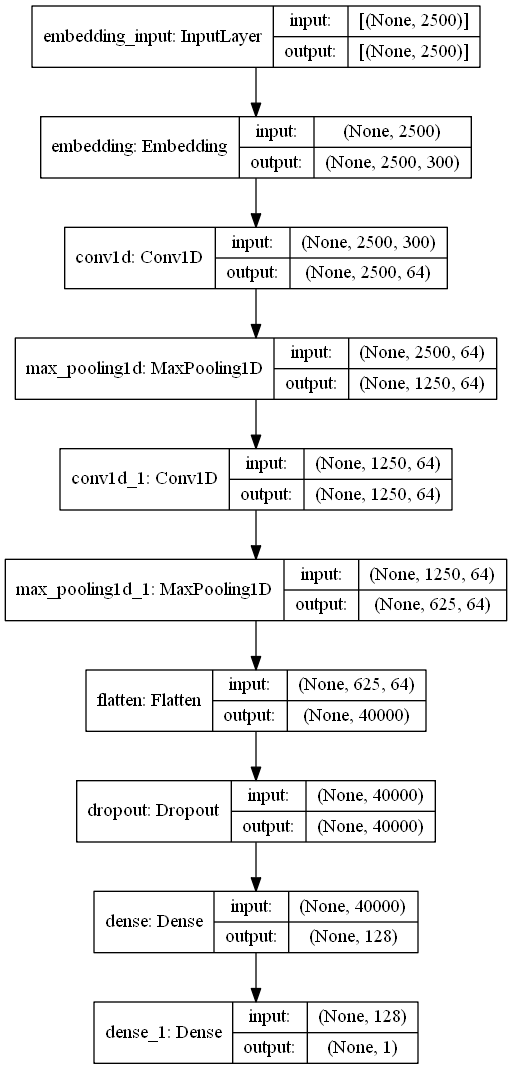

In [20]:
import graphviz
import pydot
import pydotplus
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model budeme vyhodnocovať pomocou metrík úspešnosť(Accuracy), ROC AUC, presnosť(Precission), návratnosť(Recall) a F1-skóre. Pre našu klasifikačnú úlohu detekcie falošných správ je potrebné aby sme dosiahli, čo najlepšie výsledky návratnosti, lebo chceme zachytiť všetky falošné správy.



In [16]:
print("Načítanie modelu....")
model = load_model('model.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka")
print(confusion_matrix(y_test, y_int))


Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9700811678097275
Úspešnosť je 0.9539473684210527
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1382
           1       0.95      0.52      0.67       138

    accuracy                           0.95      1520
   macro avg       0.95      0.76      0.82      1520
weighted avg       0.95      0.95      0.95      1520

Kontigenčná tabuľka
[[1378    4]
 [  66   72]]


Z vyhodnotenia modelu, môžeme vidieť že náš model je schopný presne klasifikovať falošné správy ale  nesprávne identifikoval reálne správy za falošné. To mohlo spôsobiť nevyvážený počet tried v atribúte label.

<h2>Využitie techník augmentácie dát EDA (Easy Data Augmentation)<h2>

<h3>Nahradenie synonymami<h3>

V nasledujúcej časti sa budeme zaoberať využitie techník augmentácie na rozšírenie trénovacej množiny konkrétne jej minoritnej triedy falošné správy.

Prvá metóda zo sady augmetačných techník EDA, ktorú použijeme je **Nahradenie synonymami**. Pred vytvorením funkcií pre túto metódu je potrebné načítať stop slová, ktoré budú potrebné nato aby sme vedeli, ktoré slova nemajú byť nahradené. Následne vytvorená metóda get_synonyms slúži na nájdenie všetkých synoným pre dané slovo pomocou slovníka Wordnet.
V metóde synonym_replacement je definované koľko slov má byť nahradených, taktiež že sa nemajú nahrádzať stop slová.


Následne sme vytvorili dátovú množinu *fake*, ktorá obsahovala len falošné správy z trénovacej množine teda x_train. Na túto dátovú množinu sme aplikovali metódu nahradenia synoným. Vznikla nám nová množina x_synonym, popisujúca falošné správy kde v každom texte boli maximálne 6 slová nahradenie ich synonymom. Keď sme mali vytvorenú množinu rozšírených textov bolo potrebné im zadefinovať aj hodnotenie teda, že patria k falošným textom. Kvôli tomu sme vytvorili y_synonym ktorá mala rovnaký počet riadkov ako bolo v x_synonym a v každom riadku mala hodnotu 1.

In [17]:
print("Modely rozsirenia EDA")

print("Nahradenie synonym n=6")
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)

def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def synonym_replacement(words, n=6):
    
    words = words.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #nahradia sa len n slov
            break

    sentence = ' '.join(new_words)
    new_words = sentence.split(' ')

    return sentence

fake = x_train[y_train==1]  ###množina, ktorá obsahuje len falošné správy z  trénovacej množiny
x_synonym = fake.apply(synonym_replacement) #pouzijeme funkcie na vybranu mnozinu falosnych sprav
y_synonym= np.ones(len(x_synonym)) #novym komentarom priradime hodnotenie 1

Modely rozsirenia EDA
Nahradenie synonym n=6


Ukážka dátovej množiny fake, ktorá obsahovala len falošné správy extrahované z množiny x_train.

In [21]:
print(fake.head(10))

349    Print \nHave you ever noticed how Washington a...
335    The prophecy is coming true. \nEvery cuck lose...
260    Twitter: @ batchelorshow \nFarming Invented Ma...
382    in: Multimedia , Preparedness\Survival , Scien...
45     source Add To The Conversation Using Facebook ...
428    ‘It’s for my children.’; Ammon Bundy’s testimo...
412    Thursday, 10 November 2016 Pro Rrape and Pilla...
440    Last December, Project Veritas caught NYC Demo...
436    By wmw_admin on October 28, 2016 Alana Goodman...
211    Keywords: Cardiovascular , diabetes , dietary ...
Name: text, dtype: object


Ukážka falošnej správy, v ktorej boli nahradené 6 slova ich synonymami

In [24]:
print(x_synonym[440])

Last December, Project Veritas caught NYC Democratic commissioner of the Board of Elections Alan Schulkin on hidden camera at a United Federation of Teachers holiday party admitting that there is widespread voter fraud in New York City. He explained how Muslims can use burkas as a mode to commit voter fraud. Project Veritas wanted to examination this theory by sending an undercover journalist dressed in full burka to Huma Abedin’s canvas location to see if they could vote. Shockingly, an election official offered the PV journalist Huma Abedin’s ballot. PV Journalist: “Not even just voter ID because of people voting twice, but people can similar cover their faces, you know what I’m saying?” Alan Schulkin: “The Muslims can do that too. You don’t know who they are.” PV Journalist: “The Muslims, yeah. Especially, all those Burkas. Someone could claim oh it’s my religion, but you don’t know if they are pretending or not.” Alan Schulkin: “Exactly.” Alan Schulkin: “Your vote doesn’t even coun

Ukážka povodného textu.

In [25]:
print(x_train[440])

Last December, Project Veritas caught NYC Democratic Commissioner of the Board of Elections Alan Schulkin on hidden camera at a United Federation of Teachers holiday party admitting that there is widespread voter fraud in New York City. He explained how Muslims can use burkas as a way to commit voter fraud.
Project Veritas wanted to test this theory by sending an undercover journalist dressed in full burka to Huma Abedin’s polling location to see if they could vote. Shockingly, an election official offered the PV journalist Huma Abedin’s ballot.
PV Journalist: “Not even just voter ID because of people voting twice, but people can like cover their faces, you know what I’m saying?”
Alan Schulkin: “The Muslims can do that too. You don’t know who they are.”
PV Journalist: “The Muslims, yeah. Especially, all those Burkas. Someone could claim oh it’s my religion, but you don’t know if they are pretending or not.”
Alan Schulkin: “Exactly.”
Alan Schulkin: “Your vote doesn’t even count even, be

V tejto časti sme k pôvodnej dátovej množine pridali množinu falošných správ, vytvorenou pomocou metódy nahradenia synonymami.

In [26]:
x_syn=pd.concat([x_train,x_synonym]) ##spojenie textov
y_syn=np.concatenate((y_train,y_synonym), axis=0) ###spojenie hodnotení textov
y_syn= y_syn.astype('int64')

Zobrazenie početnosti jednotlivých tried v pôvodnej množine trénovacích príkladov a v rozšírenej množine. Ako môžeme vidieť počet falošných správ sa zdojnásobil.

In [28]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_syn))

Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


Keďže metódy EDA sa aplikujú na slovnú reprezentáciu dát je potrebné dáta spracovať do vhodnej podoby pre algoritmus pomcou krokov ako sme to robili pri prvom modely.

In [29]:
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_syn)
sequences_train = tokenizer.texts_to_sequences(x_syn)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
104176


(104176, 300)



Architektúra modelu ostáva rovnaká ako v prvom modeli a to z dôvodu aby sme vedeli porovnať výsledky detekcie falošných správ.


In [30]:
####MODELOVANIE -model nahradenie synonym
model_syn = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_syn.add(e)
model_syn.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_syn.add(MaxPooling1D(2))
model_syn.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_syn.add(MaxPooling1D(2))
model_syn.add(Flatten())
model_syn.add(Dropout(0.2))
model_syn.add(Dense(128, activation='relu'))
model_syn.add(Dense(1, activation='sigmoid'))
model_syn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_syn.summary()


saved_model_syn= "model_syn.hdf5"
checkpoint = ModelCheckpoint(saved_model_syn, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


print('Training model...')
history = model_syn.fit(x_train_seq, y_syn,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2500, 300)         31252800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2500, 64)          19264     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1250, 64)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1250, 64)          4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 625, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40000)            

In [31]:
######VYHODNOTENIE
print("Loading model....")
model = load_model('model_syn.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc score is {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y_test,y_int))) #úspešnosť modelu
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int)) #kontigenčná tabuľka

import collections, numpy
print(collections.Counter(y_train)) ##početnosť tried v pôvodonej množine
print(collections.Counter(y_syn)) #početnosť tried v rozšírenej množine

Loading model....
Vyhodnotenie...
Roc auc score is 0.9780983242098198
Accuracy is 0.9651315789473685
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1382
           1       0.91      0.68      0.78       138

    accuracy                           0.97      1520
   macro avg       0.94      0.84      0.88      1520
weighted avg       0.96      0.97      0.96      1520

[[1373    9]
 [  44   94]]
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})




Z vyhodnotenia modelu môžeme vidieť, že metóda nahradenia synoným zlepšila výsledky klasifikácie. Aj keď presnosť poklesla o 3% oproti pôvodnému modelu ostatné metriky sa výrazne zlepšili. Návratnosť vzrástla o 16% čo znamená, že model bol schopný zachytiť lepšie falošné správy. Z toho vyplýva, že pomocou tejto metódy vieme lepšie klasifikovať falošné správy v dátovej množine.


<h3>Náhodné vloženie<h3>


Ďalšia augmentačná technika zo sady EDA je náhodne vloženie synoným. V tejto technike sa definujú dve funkcie. Prvá vyjadruje proces vloženia synoným kde využíva druhú funkciu, ktorá definuje nájdenie synonyma a vloženie slova. Definovali sme, že náhodne vložíme 6 synonyma na náhodnú pozíciu v texte.

Túto metódu sme na dátovú množinu aplikovali rovnako ako v predchádzajúcej množine.


In [32]:
print("Nahodne vloženie n=6")
def random_insertion(words, n=6):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

    
fake = x_train[y_train==1]
x_insert = fake.apply(random_insertion)
y_insert= np.ones(len(x_insert))

x_random_insert=pd.concat([x_train,x_insert])
y_random_insert=np.concatenate((y_train,y_insert), axis=0)
y_random_insert= y_random_insert.astype('int64')


Nahodne vloženie n=6


Zobrazenie textu, kde sme náhodne vložili 6 synonyma na náhodnu pozíciu do textu.

In [33]:
print(x_insert[440])


Last December, Project Veritas caught early NYC Democratic Commissioner of the Board of Elections Alan Schulkin on hidden camera at a United Federation of Teachers holiday party admitting that there is widespread voter fraud in New York City. He explained how Muslims can use burkas as a way to commit voter fraud. Project Veritas wanted to test this theory by sending an undercover journalist dressed election in full burka to Huma Abedin’s polling location to see if they could vote. Shockingly, an election official offered the PV election journalist Huma Abedin’s ballot. PV Journalist: “Not even just voter ID because of people voting twice, but people can like cover their faces, you know what I’m saying?” Alan Schulkin: “The Muslims can do that too. You don’t know who they are.” PV Journalist: “The Muslims, yeah. Especially, all those Burkas. helium Someone could claim oh it’s my religion, but you don’t know if they are pretending or not.” Alan Schulkin: “Exactly.” Alan Schulkin: “Your v

Pôvodný text pred rozšírením tejto metódy.

In [34]:
print(x_train[440])

Last December, Project Veritas caught NYC Democratic Commissioner of the Board of Elections Alan Schulkin on hidden camera at a United Federation of Teachers holiday party admitting that there is widespread voter fraud in New York City. He explained how Muslims can use burkas as a way to commit voter fraud.
Project Veritas wanted to test this theory by sending an undercover journalist dressed in full burka to Huma Abedin’s polling location to see if they could vote. Shockingly, an election official offered the PV journalist Huma Abedin’s ballot.
PV Journalist: “Not even just voter ID because of people voting twice, but people can like cover their faces, you know what I’m saying?”
Alan Schulkin: “The Muslims can do that too. You don’t know who they are.”
PV Journalist: “The Muslims, yeah. Especially, all those Burkas. Someone could claim oh it’s my religion, but you don’t know if they are pretending or not.”
Alan Schulkin: “Exactly.”
Alan Schulkin: “Your vote doesn’t even count even, be

Početnosti tried v pôvodnej a rozširenje množine.

In [35]:
import collections, numpy
print(collections.Counter(y_train))
print(collections.Counter(y_random_insert))

Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


Úprava dát do vhodnej podoby.

In [37]:
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_random_insert)
sequences_train = tokenizer.texts_to_sequences(x_random_insert)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
104036


(104036, 300)

In [38]:
model_interest= Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_interest.add(e)
model_interest.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_interest.add(MaxPooling1D(2))
model_interest.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_interest.add(MaxPooling1D(2))
model_interest.add(Flatten())
model_interest.add(Dropout(0.2))
model_interest.add(Dense(128, activation='relu'))
model_interest.add(Dense(1, activation='sigmoid'))
model_interest.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_interest.summary()

saved_model_interest = "model_insert.hdf5"
checkpoint = ModelCheckpoint(saved_model_interest, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_interest.fit(x_train_seq, y_random_insert,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)
model_interest.save('model_insert.hdf5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2500, 300)         31209600  
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2500, 64)          19264     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1250, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1250, 64)          4160      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 625, 64)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40000)            

In [39]:
print("Načítanie modelu....")
model = load_model('model_insert.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
# roc auc score
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

# CR/CM
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int)) ##kontigenčná tabuľka



Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9773380314184441
Úspešnosť modelu je 0.9598684210526316
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1382
           1       0.90      0.63      0.74       138

    accuracy                           0.96      1520
   macro avg       0.93      0.81      0.86      1520
weighted avg       0.96      0.96      0.96      1520

[[1372   10]
 [  51   87]]


Model, ktorý bol trénovaný dátami rozšírenej trénovacej množiny pomocou augmentačnej techniky náhodne vloženie dosiahol lepšie výsledky ako pôvodný model bez rozšírenia. Presnosť klesla o 5% ale návratnosť sa zvýšila o 11%.  Avšak táto metóda dosiahla trošku horšie výsledky ako metóda nahradenie synoným a to z dôvodu, že nové slova dosadené na náhodnú pozíciu mohli zmeniť význam textu.

<h3>Náhodná výmena<h3>

Tretia metóda je náhodná výmena. Pri tejto metóde si náhodne tri dvojice slov vymenili pozíciu v textu. Definovali sme dve metódy. V prvej sa definuje ako si vymenia slová pozície a v druhej sme definovali, koľko slov sa má vymeniť a pomocou prvej metódy sa tento proces uskutočnil.

Tak ako v predchádzajúcich metódach sme následne použili metódu na fake množinu a vytvorili sme nové trénovacie príklady, ktoré mali duplicitné falošné správy.  Následne upravíme dáta do vhodnej podoby a trénujeme model.

In [40]:
print("Nahodne výmena n=3")
def swap_word(new_words):
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def random_swap(words, n=3): 
    words = words.split()
    new_words = words.copy()
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence


fake = x_train[y_train==1]
x_swap = fake.apply(random_swap)
y_swap= np.ones(len(x_swap))

x_random_swap=pd.concat([x_train,x_swap])
y_random_swap=np.concatenate((y_train,y_swap), axis=0)
y_random_swap= y_random_swap.astype('int64')

print(collections.Counter(y_train))
print(collections.Counter(y_random_swap))

Nahodne výmena n=3
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


Ukážka textu, v ktorom si tri slová vymenili pozíciu.

In [41]:
print(x_swap[440])

Last December, Project Veritas caught NYC Democratic Commissioner that the Board of Elections Alan Schulkin on hidden camera at a United Federation of Teachers holiday party admitting that there is widespread voter fraud in New York City. He explained how Muslims can use burkas as a way to commit voter fraud. Project Veritas wanted to test this theory by sending an undercover journalist dressed in full burka to Huma Abedin’s polling location to see if they could vote. Shockingly, an election official offered the PV journalist Huma Abedin’s ballot. PV Journalist: “Not even just voter ID because of people voting twice, but people can like cover their faces, you know what I’m saying?” Alan Schulkin: “The Muslims can do that too. You don’t know who they are.” PV Journalist: “The Muslims, yeah. Especially, all those Burkas. Someone or claim oh it’s my religion, but you don’t know if they are pretending could not.” Alan Schulkin: for Alan Schulkin: “Your vote doesn’t even count even, because

Pôvodný text v trénovacej množine

In [42]:
print(x_train[440])

Last December, Project Veritas caught NYC Democratic Commissioner of the Board of Elections Alan Schulkin on hidden camera at a United Federation of Teachers holiday party admitting that there is widespread voter fraud in New York City. He explained how Muslims can use burkas as a way to commit voter fraud.
Project Veritas wanted to test this theory by sending an undercover journalist dressed in full burka to Huma Abedin’s polling location to see if they could vote. Shockingly, an election official offered the PV journalist Huma Abedin’s ballot.
PV Journalist: “Not even just voter ID because of people voting twice, but people can like cover their faces, you know what I’m saying?”
Alan Schulkin: “The Muslims can do that too. You don’t know who they are.”
PV Journalist: “The Muslims, yeah. Especially, all those Burkas. Someone could claim oh it’s my religion, but you don’t know if they are pretending or not.”
Alan Schulkin: “Exactly.”
Alan Schulkin: “Your vote doesn’t even count even, be

In [43]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_random_swap)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matica....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matica....
103870


(103870, 300)

In [44]:
model_swap = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_swap.add(e)
model_swap.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_swap.add(MaxPooling1D(2))
model_swap.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_swap.add(MaxPooling1D(2))
model_swap.add(Flatten())
model_swap.add(Dropout(0.2))
model_swap.add(Dense(128, activation='relu'))
model_swap.add(Dense(1, activation='sigmoid'))
model_swap.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_swap.summary()

saved_model_swap = "model_swap.hdf5"
checkpoint = ModelCheckpoint(saved_model_swap, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Ténovanie modelu...')
history = model_swap.fit(x_train_seq, y_random_swap,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2500, 300)         31161000  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2500, 64)          19264     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1250, 64)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1250, 64)          4160      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 625, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 40000)            

In [45]:
print("Načítanie modelu....")
model = load_model('model_swap.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
# roc auc score
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

# CR/CM
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print("Kontigenčná tabuľka modelu:")
print(confusion_matrix(y_test, y_int))


print(collections.Counter(y_train)) ##početnosť tried v pôvodnej množine
print(collections.Counter(y_random_swap)) #početnosť tried v rozšírenej množine

Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9784653621091046
Úspešnosť je 0.9651315789473685
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1382
           1       0.96      0.64      0.77       138

    accuracy                           0.97      1520
   macro avg       0.96      0.82      0.88      1520
weighted avg       0.96      0.97      0.96      1520

Kontigenčná tabuľka modelu:
[[1378    4]
 [  49   89]]
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 920})


Pomocou tejto augmetačnej metódy model dosiahol zlepšenie pri všetkých metrikách oproti pôvodnému modelu. Presnosť sa zväčšila o 1% návratnosť o 12% a celkové F1-skóre až o 10%.

<h3> Náhodné vymazanie<h3>

Posledná metóda zo sady metód EDA je náhodne vymazanie. V tejto sa definuje pravdepodobnosť podľa, ktorej majú byť slová vymazané z textu. V našom prípade sme definovali pravdepodobnosť 0.12. Ak je v texte málo slov neodstránia sa žiadne slová. Tak ako v prechádzajúcich metódach sme v trénovacej množine zdvojnásobili počet falošných správ. Následne sme vytvorili model a vyhodnotili sme ho.

In [47]:
print("Nahodne vymazanie p=0.12")
def random_deletion(words, p=0.12):
    words = words.split()
    if len(words) == 1:
        return words

    #skutocne mazat slovs pravdepodobnostou str
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
 
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence


x_del = fake.apply(random_deletion)
y_del= np.ones(len(x_del))
x_random_del=pd.concat([x_train,x_del])
y_random_del=np.concatenate((y_train,y_del), axis=0)
y_random_del= y_random_del.astype('int64')

Nahodne vymazanie p=0.12


In [48]:
print(x_del[440])

Last December, Project Veritas caught Democratic Commissioner of Board of Elections Alan Schulkin on hidden camera a United Federation of Teachers holiday party that there widespread voter fraud New York City. He how Muslims use burkas as a way to commit voter Project Veritas wanted to test this theory by an undercover journalist dressed in full burka Huma Abedin’s polling location to see they could vote. Shockingly, an election official offered the PV journalist Huma Abedin’s ballot. PV Journalist: “Not even just voter ID because of people voting but people like cover their faces, you know what I’m Schulkin: “The Muslims can do that too. don’t know who they are.” PV Journalist: “The Muslims, Especially, all those Burkas. Someone could claim oh it’s my religion, but you don’t know if they are pretending or Alan Schulkin: “Exactly.” Alan Schulkin: “Your vote doesn’t even count even, because they can go in there with a burka and you don’t know if they are a voter. Your vote gets discount

In [49]:
print(x_train[440])

Last December, Project Veritas caught NYC Democratic Commissioner of the Board of Elections Alan Schulkin on hidden camera at a United Federation of Teachers holiday party admitting that there is widespread voter fraud in New York City. He explained how Muslims can use burkas as a way to commit voter fraud.
Project Veritas wanted to test this theory by sending an undercover journalist dressed in full burka to Huma Abedin’s polling location to see if they could vote. Shockingly, an election official offered the PV journalist Huma Abedin’s ballot.
PV Journalist: “Not even just voter ID because of people voting twice, but people can like cover their faces, you know what I’m saying?”
Alan Schulkin: “The Muslims can do that too. You don’t know who they are.”
PV Journalist: “The Muslims, yeah. Especially, all those Burkas. Someone could claim oh it’s my religion, but you don’t know if they are pretending or not.”
Alan Schulkin: “Exactly.”
Alan Schulkin: “Your vote doesn’t even count even, be

In [50]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_random_del)
sequences_train = tokenizer.texts_to_sequences(x_random_del)
sequences_test = tokenizer.texts_to_sequences(x_test)


x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
103870


(103870, 300)

In [51]:
model_del = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_del.add(e)
model_del.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_del.add(MaxPooling1D(2))
model_del.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_del.add(MaxPooling1D(2))
model_del.add(Flatten())
model_del.add(Dropout(0.2))
model_del.add(Dense(128, activation='relu'))
model_del.add(Dense(1, activation='sigmoid'))
model_del.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_del.summary()

saved_model_del = "model_del.hdf5"
checkpoint = ModelCheckpoint(saved_model_del, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_del.fit(x_train_seq, y_random_del, epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 2500, 300)         31161000  
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2500, 64)          19264     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1250, 64)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1250, 64)          4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 625, 64)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 40000)            

In [52]:
print("Loading model....")
model = load_model('model_del.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc score is {}'.format(roc_auc_score(y_test,y_pred)))


y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print("Accuracy is {}".format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

collections.Counter(y_train)
collections.Counter(y_random_del)

Loading model....
Vyhodnotenie...
Roc auc score is 0.9757545250529582
Accuracy is 0.9618421052631579
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1382
           1       0.93      0.63      0.75       138

    accuracy                           0.96      1520
   macro avg       0.94      0.81      0.86      1520
weighted avg       0.96      0.96      0.96      1520

[[1375    7]
 [  51   87]]


Counter({0: 5618, 1: 920})

V tej poslednej augmentačnej technike zo sady metód EDA sa potvrdilo ako v predchádzajúcich technikách zlepšenie výsledkov model pri detekcií antisociálneho správania. Tieto všetky techniky dosiahli viditeľné zlepšenie návratnosti o viac ako 10% z čoho vyplýva, že výrazne vedia dopomôcť k lepším výsledkom klasifikácie. A sú vhodným nástrojom pre vyváženie početnosti tried v atribútoch.

<h3>Spojenie metód EDA<h3>

Po vytvorení samostatných modelov pre každú augmentačnú techniku zo sady techník EDA sme vytvorili jeden model, ktorý tieto všetky metódy spojil. To znamená pomocou všetkých 4 metódach, ktoré sme využili vyššie sme vytvorili novú trénovaiu množinu. Táto množina mala 4násobne viac falošných správ ako pôvodná. Všetky falošné správy vytvorené pomocou augmentačných techník vyššie sme spojili do jednej trénovacej množiny. Následne sme ako v predchádzajúcich modeloch dáta upravili do vhodnej podoby  a trénovali sme model.

In [56]:
###vytvorenie modelu pomcou všetkých augmentačných techník EDA
##hodnoty zadané v metódach sú také ako sme definovali vyššie
print("Modely rozsirenia EDA")
x_eda=np.concatenate((x_synonym,x_swap,x_insert,x_del,x_train), axis=0)
y_eda=np.concatenate((y_synonym,y_swap,y_insert,y_del,y_train), axis=0)
y_eda= y_eda.astype('int64')

print(collections.Counter(y_train))
print(collections.Counter(y_eda))



Modely rozsirenia EDA
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 2300})


In [62]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_eda)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
103870


(103870, 300)

In [63]:
model_eda = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_eda.add(e)
model_eda.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_eda.add(MaxPooling1D(2))
model_eda.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_eda.add(MaxPooling1D(2))
model_eda.add(Flatten())
model_eda.add(Dropout(0.2))
model_eda.add(Dense(128, activation='relu'))
model_eda.add(Dense(1, activation='sigmoid'))
model_eda.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_eda.summary()

saved_eda = "model_eda4_metody.hdf5"
checkpoint = ModelCheckpoint(saved_eda, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_eda.fit(x_train_seq, y_eda,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2500, 300)         31161000  
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 2500, 64)          19264     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 1250, 64)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1250, 64)          4160      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 625, 64)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 40000)            

In [64]:
print("Načítanie modelu....")
model = load_model('model_eda4_metody.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

print("Počet real/fake v pôvodnej množine")
print(collections.Counter(y_train))
print("Počet real/fake v rozširenej množine")
print(collections.Counter(y_eda))

Načítanie modelu....
Vyhodnotenie...
Roc auc skóre je 0.9856121143480359
Úspešnosť modelu je 0.9769736842105263
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1382
           1       0.95      0.79      0.86       138

    accuracy                           0.98      1520
   macro avg       0.96      0.89      0.92      1520
weighted avg       0.98      0.98      0.98      1520

[[1376    6]
 [  29  109]]
Počet real/fake v pôvodnej množine
Counter({0: 5618, 1: 460})
Počet real/fake v rozširenej množine
Counter({0: 5618, 1: 2300})


Spojenie metód EDA dosiahlo pri detekcií falošných správ najlepšie výsledky. Z toho vyplýva, že keď sme automaticky zväčšili triedu falošné správy na väčší počet tak sme dosiahli aj lepšie výsledky klasifikácie.  

<h4>Spojenie troch metód, ktoré dosiahli najlepšie výsledky<h4>

V tomto poslednom modeli sme využili augmetačné techniky, ktoré dosiahli najlepšie výsledky. Teda sme nepoužili rozšírenie pomocou metódy náhodne vloženie, lebo dosiahla najnižšie zlepšenie. V tomto modely sme postupovali ako v predchádzajúcom. Rozdiel bol len taký, že falošné správy sme strojnásobili.

In [65]:
print("Spojenie najlepších metód EDA")
x_eda=np.concatenate((x_synonym,x_swap,x_del,x_train), axis=0)
y_eda=np.concatenate((y_synonym,y_swap,y_del,y_train), axis=0)
y_eda= y_eda.astype('int64')

print(collections.Counter(y_train))
print(collections.Counter(y_eda))

Spojenie najlepších metód EDA
Counter({0: 5618, 1: 460})
Counter({0: 5618, 1: 1840})


In [66]:
print("Tokenizacia")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_eda)
sequences_test = tokenizer.texts_to_sequences(x_test)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
103870


(103870, 300)

In [67]:
model_eda = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model_eda.add(e)
model_eda.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_eda.add(MaxPooling1D(2))
model_eda.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model_eda.add(MaxPooling1D(2))
model_eda.add(Flatten())
model_eda.add(Dropout(0.2))
model_eda.add(Dense(128, activation='relu'))
model_eda.add(Dense(1, activation='sigmoid'))
model_eda.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_eda.summary()

saved_eda = "model_eda3_metody.hdf5"
checkpoint = ModelCheckpoint(saved_eda, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Trénovanie modelu...')
history = model_eda.fit(x_train_seq, y_eda,epochs=5, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 2500, 300)         31161000  
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 2500, 64)          19264     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1250, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1250, 64)          4160      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 625, 64)           0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 40000)            

In [68]:
print("Loading model....")
model = load_model('model_eda3_metody.hdf5')
print("Vyhodnotenie...")
y_pred = model.predict(x_test_seq)
print('Roc auc skóre je {}'.format(roc_auc_score(y_test,y_pred)))

y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť modelu je {}'.format(accuracy_score(y_test,y_int)))
print(classification_report(y_test, y_int, zero_division=0))
print(confusion_matrix(y_test, y_int))

print("Počet real/fake v pôvodnej množine")
print(collections.Counter(y_train))
print("Počet real/fake v rozširenej množine")
print(collections.Counter(y_eda))

Loading model....
Vyhodnotenie...
Roc auc skóre je 0.9878038549466222
Úspešnosť modelu je 0.9730263157894737
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1382
           1       0.93      0.76      0.84       138

    accuracy                           0.97      1520
   macro avg       0.95      0.88      0.91      1520
weighted avg       0.97      0.97      0.97      1520

[[1374    8]
 [  33  105]]
Počet real/fake v pôvodnej množine
Counter({0: 5618, 1: 460})
Počet real/fake v rozširenej množine
Counter({0: 5618, 1: 1840})


Model dosiahol oproti pôvodnému modelu zlepšenie. Avšak nezlepšil výsledky klasifikácie, až tak ako model vytvorený zo všetkých augmetačncýh metód EDA. Čo môže znamenať, že čím viac rozširujeme triedu falošné správy tým lepšie dostávame výsledky klasifikácie